In [4]:
import warnings

import botorch
import gpytorch
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from bo.models import BotorchGPModel
from bo.train import fit_gp_model
import bo.plots

torch.manual_seed(0);

In [5]:
def f(x):
    return (
        torch.sin(5 * x[..., 0] / 2 - 2.5) * torch.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2


lb = 0
ub = 2

bounds = torch.tensor([[lb, lb], [ub, ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = f(xs)

In [6]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
num_queries = 20
batch_size = 4
num_iters = num_queries // batch_size

In [9]:
strategy = "poi"  # "poi", "ei", "ucb"
strategy = strategy.upper()

torch.manual_seed(0)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 2)
train_y = f(train_x)

incumbents = torch.zeros(num_iters)
for i in tqdm(range(num_iters)):
    incumbents[i] = train_y.max()

    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    fit_gp_model(model, likelihood, train_x, train_y)

    if strategy == "POI":
        policy = botorch.acquisition.monte_carlo.qProbabilityOfImprovement(
            model, best_f=train_y.max()
        )
    if strategy == "EI":
        policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
            model, best_f=train_y.max()
        )
    if strategy == "UCB":
        policy = botorch.acquisition.monte_carlo.qUpperConfidenceBound(model, beta=2)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        next_x, acq_val = botorch.optim.optimize_acqf(
            policy,
            bounds=bounds,
            q=batch_size,
            num_restarts=40,
            raw_samples=100,
        )

    next_y = f(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
!mkdir hyperparam_tuning
torch.save(incumbents, f"./hyperparam_tuning/{strategy}.pth")

mkdir: hyperparam_tuning: File exists


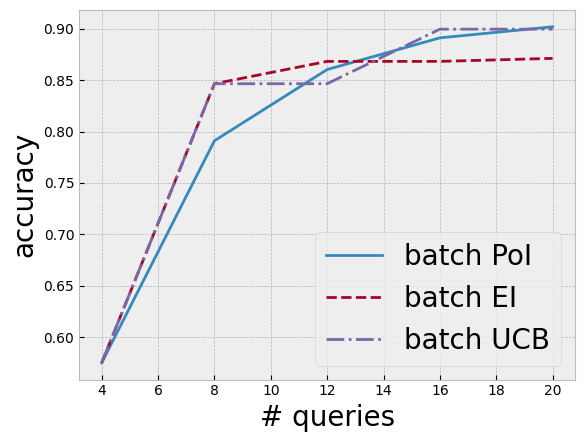

In [11]:
q_poi_incumbents = torch.load("./hyperparam_tuning/POI.pth")
q_ei_incumbents = torch.load("./hyperparam_tuning/EI.pth")
q_ucb_incumbents = torch.load("./hyperparam_tuning/UCB.pth")

xs = (torch.arange(num_iters) + 1) * batch_size

plt.plot(xs, q_poi_incumbents, label="batch PoI")
plt.plot(xs, q_ei_incumbents, linestyle="--", label="batch EI")
plt.plot(xs, q_ucb_incumbents, linestyle="-.", label="batch UCB")

plt.xlabel("# queries", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.legend(fontsize=20)

plt.show()